In [162]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from typing import List
from typing import Tuple
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import ClusterCentroids
from sklearn.svm import SVC

In [155]:
df = pd.read_csv('Credit_Card.csv')
label_df = pd.read_csv('Credit_card_label.csv')
merged_df = pd.merge(df, label_df, on='Ind_ID')

# 1. (5 pts) Perform additional cleaning beyond what you did in Assignment 6. Specify the improvements you made. 

In [156]:
def clean_and_encode_data(merged_df: pd.DataFrame, 
                          numerical_cols: List[str] = ['Annual_income', 'Birthday_count', 'Employed_days'], 
                          categorical_cols: List[str] = ['GENDER', 'Car_Owner', 'Propert_Owner', 'Type_Income', 
                                                         'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation'], 
                          occupation_col: str = 'Type_Occupation') -> pd.DataFrame:
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())
    
    merged_df.dropna(subset=[occupation_col], inplace=True)
    
    merged_df['GENDER'] = merged_df['GENDER'].fillna(merged_df['GENDER'].mode()[0])
    
    df_encoded = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)

    df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan).fillna(0)

    df_encoded = df_encoded.astype(int)

    sc = StandardScaler()
    df_encoded[numerical_cols] = sc.fit_transform(df_encoded[numerical_cols])
    return df_encoded
df_encoded = clean_and_encode_data(merged_df)
df_encoded

,Ind_ID,CHILDREN,Annual_income,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Family_Members,...,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
8,5010864,1,2.047160,-0.909858,0.842207,1,0,1,1,3,...,0,0,0,0,0,0,0,0,0,0
9,5010868,1,2.047160,-0.909858,0.842207,1,0,1,1,3,...,0,0,0,0,0,0,0,0,0,0
10,5010869,1,2.047160,-0.909858,0.842207,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
11,5018498,0,-0.878721,-1.110597,0.706227,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
12,5018501,0,-1.610191,-1.110597,0.706227,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,5118268,1,1.315690,0.867338,-0.357267,1,0,1,0,3,...,0,0,0,0,0,0,0,0,0,0
1543,5028645,0,-1.610191,0.696052,0.210993,1,0,0,0,2,...,0,0,1,0,0,0,0,0,0,0
1544,5023655,0,0.218485,1.142482,0.619351,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1545,5115992,2,-0.147250,0.381638,0.087185,1,0,0,0,4,...,0,0,1,0,0,0,0,0,0,0


There wasn't much more I could do from assignment 6 so I removed/replaced any remaining null values and standardized the data.

In [157]:
label_counts = df_encoded['label'].value_counts()
label_counts

label
0    942
1    118
Name: count, dtype: int64

# 2. (8 pts) Perform combined, oversampling, or undersampling on the dataset you selected for Assignment 6.  Explain why you chose what you did. How did this impact the results of your KNN and Logistic Regression? 

In [158]:
def apply_smoteenn(X:int, y:int):
    
    smoteenn = SMOTEENN(random_state=42)
    X_resampled, y_resampled = smoteenn.fit_resample(X, y)
    return X_resampled, y_resampled


In [159]:
def train_logistic_regression(df_encoded: pd.DataFrame) -> float:
    X = df_encoded.drop(columns=['label', 'Ind_ID'])
    y = df_encoded['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_resampled, y_train_resampled = apply_smoteenn(X_train, y_train)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train_resampled, y_train_resampled)

    y_pred = log_reg.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report
accuracy, report = train_logistic_regression(df_encoded)
print(accuracy)
print(report)

0.660377358490566
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       181
           1       0.17      0.35      0.23        31

    accuracy                           0.66       212
   macro avg       0.52      0.53      0.51       212
weighted avg       0.76      0.66      0.70       212



In [160]:
def find_optimal_k(df_encoded: pd.DataFrame, 
                   target_col: str, 
                   k_range: Tuple[int, int] = (1, 21), 
                   test_size: float = 0.2, 
                   random_state: int = 42) -> float:

    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train_resampled, y_train_resampled = apply_smoteenn(X_train, y_train)
    best_k = 0
    best_score = 0
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=((2*k)+1))
        knn.fit(X_train_resampled, y_train_resampled)
        score = knn.score(X_test, y_test)
        if score > best_score:
            best_k = k
            best_score = score

    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train_resampled, y_train_resampled)

    y_pred = knn.predict(X_test)
    y_probs = knn.predict_proba(X_test)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    return best_k, test_accuracy, conf_matrix, class_report, y_test, y_probs

best_k, test_accuracy, conf_matrix, class_report, y_test, y_probs = find_optimal_k(df_encoded, target_col='label')

print(f"Optimal k: {best_k}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Optimal k: 1
Test Accuracy: 0.7405660377358491
Confusion Matrix:
[[144  37]
 [ 18  13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       181
           1       0.26      0.42      0.32        31

    accuracy                           0.74       212
   macro avg       0.57      0.61      0.58       212
weighted avg       0.80      0.74      0.76       212



I used combined or SMOTEENN more specifically becasue SMOTEENN uses oversampling to balance classes and ENN to remove noisy samples, preventing overfitting to synthetic data. And unlike pure undersampling, SMOTEENN keeps more data from both classes, preserving useful information. While the accuracy with SMOTEENN improved accuracy of both knn and logistic regression models, it performed even worse predicting minority class.

# 3. (3 pts) Create an ROC Curve for the model and calculate the AUC.

Optimal k: 1
Test Accuracy: 0.7405660377358491
Confusion Matrix:
[[144  37]
 [ 18  13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       181
           1       0.26      0.42      0.32        31

    accuracy                           0.74       212
   macro avg       0.57      0.61      0.58       212
weighted avg       0.80      0.74      0.76       212



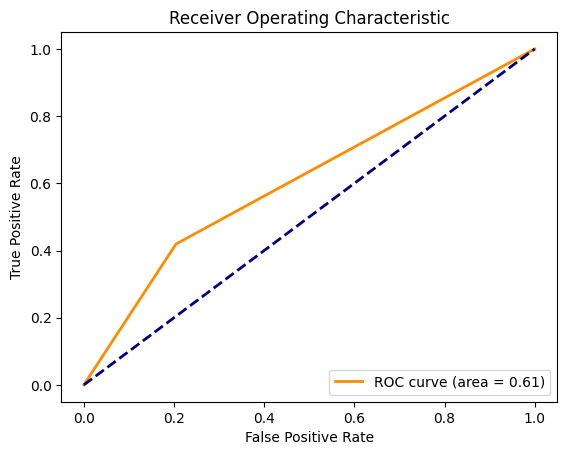

ROC AUC: 0.6074674746034575


In [161]:
def plot_roc_curve(y_test: np.ndarray, y_probs: np.ndarray) -> float:
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
    return roc_auc


best_k, test_accuracy, conf_matrix, class_report, y_test, y_probs = find_optimal_k(df_encoded, target_col='label')

print(f"Optimal k: {best_k}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

roc_auc = plot_roc_curve(y_test, y_probs)
print(f"ROC AUC: {roc_auc}")

# 4. (7 pts) Perform a linear SVM to predict the result from your dataset.

In [164]:
def train_evaluate_svm(df_encoded: pd.DataFrame, target_column: str = 'label') -> None:
    X = df_encoded.drop(['Ind_ID', target_column], axis=1)
    y = df_encoded[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    classifier = SVC(kernel='linear', random_state=42)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
train_evaluate_svm(df_encoded)

Accuracy: 0.8742
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       275
           1       1.00      0.07      0.13        43

    accuracy                           0.87       318
   macro avg       0.94      0.53      0.53       318
weighted avg       0.89      0.87      0.82       318



The overall accuracy of the model is good. However, the model performs well in terms of accuracy and precision for class 0, but it struggles significantly with recall for class 1, leading to a low F1-score for that class. This suggests that the model may be biased towards the majority class (class 0), which can be an issue, especially if class 1 is critical for the application.

# 5. (2 pts) What is outlier detection? Why is it important? What methods can you use for outlier detection?

Outlier detection identifies data points that deviate significantly from the majority of a dataset, known as outliers. These anomalies can stem from measurement errors, data entry mistakes, or genuine variations. Detecting outliers is crucial for improving data quality as they can hinder data integrity. Several methods exist for outlier detection. Statistical techniques include the Z-Score, which measures deviations from the mean, and the Interquartile Range (IQR), which identifies outliers based on data spread. 